In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bert-10000/BERT_10000.pth
/kaggle/input/cleaneddatasetfornlp/Cleaned/CleanedTest.csv
/kaggle/input/cleaneddatasetfornlp/Cleaned/CleanedTrain.csv
/kaggle/input/amazon-reviews/amazon_review_polarity_csv.tgz
/kaggle/input/amazon-reviews/train.csv
/kaggle/input/amazon-reviews/test.csv


In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertForMaskedLM

In [4]:
data=pd.read_csv('/kaggle/input/cleaneddatasetfornlp/Cleaned/CleanedTrain.csv')

In [5]:
data = data[['Polarity', 'Review']].reset_index(drop=True)
data.head()

,Polarity,Review
0,2,sound track beautiful paints senery mind well ...
1,2,im reading lot reviews saying best game soundt...
2,2,soundtrack favorite music time hands down inte...
3,2,truly like soundtrack enjoy video game music p...
4,2,played game know divine music is every single ...


In [6]:
# Define a function to map sentiment values
def map_values(value):
    if value == 1:
        return "negative"
    elif value == 2:
        return "positive"

In [7]:
data['sentiment'] = data['Polarity'].apply(map_values)

In [8]:
data.head(10)

,Polarity,Review,sentiment
0,2,sound track beautiful paints senery mind well ...,positive
1,2,im reading lot reviews saying best game soundt...,positive
2,2,soundtrack favorite music time hands down inte...,positive
3,2,truly like soundtrack enjoy video game music p...,positive
4,2,played game know divine music is every single ...,positive
5,2,quite sure actually taking time read played ga...,positive
6,1,selfpublished book want know whyread paragraph...,negative
7,2,loved whisper wicked saints story amazing plea...,positive
8,2,finished reading whisper wicked saints fell lo...,positive
9,2,easy read book made want keep reading on easy ...,positive


In [9]:
 def load_data(data):
     texts = data['Review'].tolist()
     labels = [1 if sentiment == "positive" else 0 for sentiment in data['sentiment'].tolist()]
     return texts, labels

In [10]:
subset_size = 10000
subset = data.sample(n=subset_size, random_state=42)
subset

,Polarity,Review,sentiment
1711148,2,book must anyone wants contribute remaining qu...,positive
3417606,2,one best thought provoking books read last ten...,positive
4453,1,want specific color random one thanks reviews ...,negative
3538239,1,book composed exquisitely yet unmistakenly ful...,negative
3288877,1,boy show go downhill first season great high h...,negative
...,...,...,...
420987,1,waste money time tempting contraption lot mail...,negative
1476416,1,simialr experience many others lexmark cartrid...,negative
1011908,2,food pretty realistic allowing peel cut play k...,positive
1844255,1,recently listing dvd appeared unaware dvd yet ...,negative


In [11]:
value_counts=subset.Polarity.value_counts()
value_counts

Polarity
1    5062
2    4938
Name: count, dtype: int64

<Axes: xlabel='Polarity'>

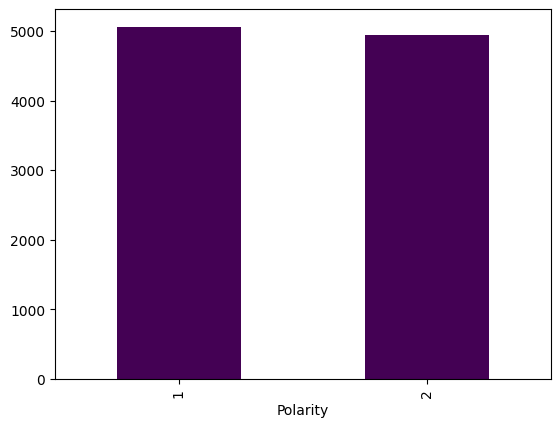

In [12]:
value_counts.plot(kind="bar",x=value_counts.keys,colormap='viridis')

In [13]:
# Extract texts and labels
texts, labels = load_data(subset)

* Text classification class is used to load and batch data for training models 

* self.text is creating a list for sentences
 
* self.labels is creating a list for corresponding labels

* self.tokenizer is an object for tokenization

* and max_length is for maximum tokenized texts

* __init__ method assigns these parameters to instance variables of the class for later use

* __len__ returns the number of texts

* __getitem__ is used for retrieving data

In [3]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}


* Here the bertclassifier takes 2 parameters

* bert_model_name the name or path of model passed to the pre-trained bert model
 
* num_classes is the number of output classes for classification

In [4]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

* this function is to train model using the given parameters 

* model.train() sets the model in training model

* for batch in data_loader is a loop that iterates over the batches of data provided by the data_loader as each batch typically contains a batch of input data and corresponding labels

* optimizer.zero_grad() line clears the gradients of the model parameters

* next lines extract the input tensors (input_ids and attention_mask) and labels from the batch dictionary and move them to the specified device

* output line passes the input tensors through the model to obtain the model's predictions, the input_ids represent the tokenized input sequence and the attention_mask indicates which tokens should be attended to and which should be ignored

* The function continues to iterate over the batches in the data loader, calculating the loss and updating the model parameters until all batches have been processed

In [5]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

**The function iterates over the batches in the data loader, obtaining predictions and actual labels, and then returns the accuracy score and a classification report summarizing the model's performance on the evaluation data**

In [6]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

**The function preprocesses the input text using the tokenizer, passes it through the model to obtain predictions, and returns the predicted sentiment label**

**It assumes a binary classification task where the model predicts positive or negative sentiment**

In [7]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        return "positive" if preds.item() == 1 else "negative"


In [8]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

In [20]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [21]:
print("train_texts : ",np.shape(train_texts))
print("val_texts : ",np.shape(val_texts))
print("train_labels : ",np.shape(train_labels))
print("val_labels : ",np.shape(val_labels))

train_texts :  (8000,)
val_texts :  (2000,)
train_labels :  (8000,)
val_labels :  (2000,)


In [22]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [11]:
# Load the model after saving it
model.load_state_dict(torch.load("/kaggle/input/bert-10000/BERT_10000.pth"))

<All keys matched successfully>

In [25]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/4
Validation Accuracy: 0.8540
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       979
           1       0.86      0.85      0.86      1021

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

Epoch 2/4
Validation Accuracy: 0.8685
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       979
           1       0.86      0.89      0.87      1021

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000

Epoch 3/4
Validation Accuracy: 0.8575
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       979
           1       0.86      0.86      0.86      1021

    accuracy                           0.86      2000
   macro avg  

In [ ]:
# Get predictions and actual labels
predictions = []
actual_labels = []
with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        predictions.extend(preds.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(actual_labels, predictions)

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [27]:
# Save the model after train
torch.save(model.state_dict(), "NEW_BERT.pth")

In [12]:
# Test sentiment prediction in negative
test_text2 = "I purchased this product with high hopes, but it turned out to be a total waste of money"
sentiment2 = predict_sentiment(test_text2, model, tokenizer, device)
print(f"Predicted sentiment: {sentiment2}")

Predicted sentiment: negative


In [13]:
# Test sentiment prediction in positive
test_text = "sound track beautiful paints senery mind"
sentiment = predict_sentiment(test_text, model, tokenizer, device)
print(f"Predicted sentiment: {sentiment}")

Predicted sentiment: positive
